# Initialisation

In [ ]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    if not os.path.exists('/content/drive'):
      drive.mount('/content/drive/')
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

Mounted at /content/drive/
/content/drive/MyDrive/nov23_bds_rakuten


In [ ]:
random_state = 42

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pathlib import Path
import re
from tqdm import tqdm
import pickle as pickle

import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback,EarlyStopping, LearningRateScheduler
from tensorflow.keras import backend as K
import keras.saving

from keras.utils import to_categorical
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tf_keras_vis.activation_maximization import ActivationMaximization

In [ ]:
#np.random.seed(42)

# Librairie de fonctions

In [ ]:
def f1_score_sklearn(y_true, y_pred):
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return f1_score(y_true_classes, y_pred_classes, average='weighted')

@keras.saving.register_keras_serializable(name='w_f1_score')
def w_f1_score(y_true, y_pred):
    f1 = tf.py_function(f1_score_sklearn, (y_true, y_pred), tf.float64)
    return f1

In [ ]:
prdcodetype2label = {
    10 : "Livre occasion",
    40 : "Jeu vidéo, accessoire tech",
    50 : "Accessoire Console",
    60 : "Console de jeu",
    1140 : "Figurine",
    1160 : "Carte Collection",
    1180 : "Jeu Plateau",
    1280 : "Jouet enfant,déguisement",
    1281 : "Jeu société",
    1300 : "Jouet tech",
    1301 : "Jeu intérieur,chaussettes",
    1302 : "Jeu extérieur,vêtement",
    1320 : "Bébé",
    1560 : "Mobilier intérieur",
    1920 : "Chambre",
    1940 : "Cuisine",
    2060 : "Décoration intérieure",
    2220 : "Animal",
    2280 : "Revues,journaux",
    2403 : "Magazines,livres,BDs",
    2462 : "Jeu occasion",
    2522 : "Bureautique,papeterie",
    2582 : "Mobilier extérieur",
    2583 : "Piscine",
    2585 : "Bricolage",
    2705 : "Livre neuf",
    2905 : "Jeu PC",
}

# Import des données

In [ ]:
df_test = pd.read_csv("output/data-preprocessing-resampling/df_test.csv",index_col=0)

In [ ]:
classes_keras = list(np.sort(np.array(df_test["prdtypecode"].unique(),dtype="str")))

# Chargement du modèle

In [ ]:
model_path = "output/data-modeling-images-3/model-331.keras"
model_path_obj = Path(model_path)
print("Load model from",model_path)
model = load_model(model_path)

Load model from output/data-modeling-images-3/model-331.keras


# Activation maximization

## Test 1

In [ ]:

def loss(output):
  output = [output[i,i] for i in range(len(classes_keras))]
  return tuple(output)


def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Initialize Activation Maximization
visualize_activation = ActivationMaximization(model, model_modifier)

# Generate a random seed for each activation
seed_input = tf.random.uniform((len(classes_keras), 224, 224, 3), 0, 255)

# Generate activations and convert into images
activations = visualize_activation(loss, seed_input=seed_input, steps=512, input_range=(30,150))


In [ ]:
def plot_activation_images(activations):
  images = [activation.numpy().astype(np.uint8) for activation in activations]

  #plt.figure(figsize=(15,40 * len(images)//len(classes_keras)) )
  plt.figure(figsize=(15,40) )
  for i in range(len(images)):
    plt.subplot(9,3,i+1)
    visualization = images[i]
    plt.imshow(visualization)
    plt.title(classes_keras[i]+": "+prdcodetype2label[int(classes_keras[i])])
    plt.xticks([])
    plt.yticks([])

  plt.show()

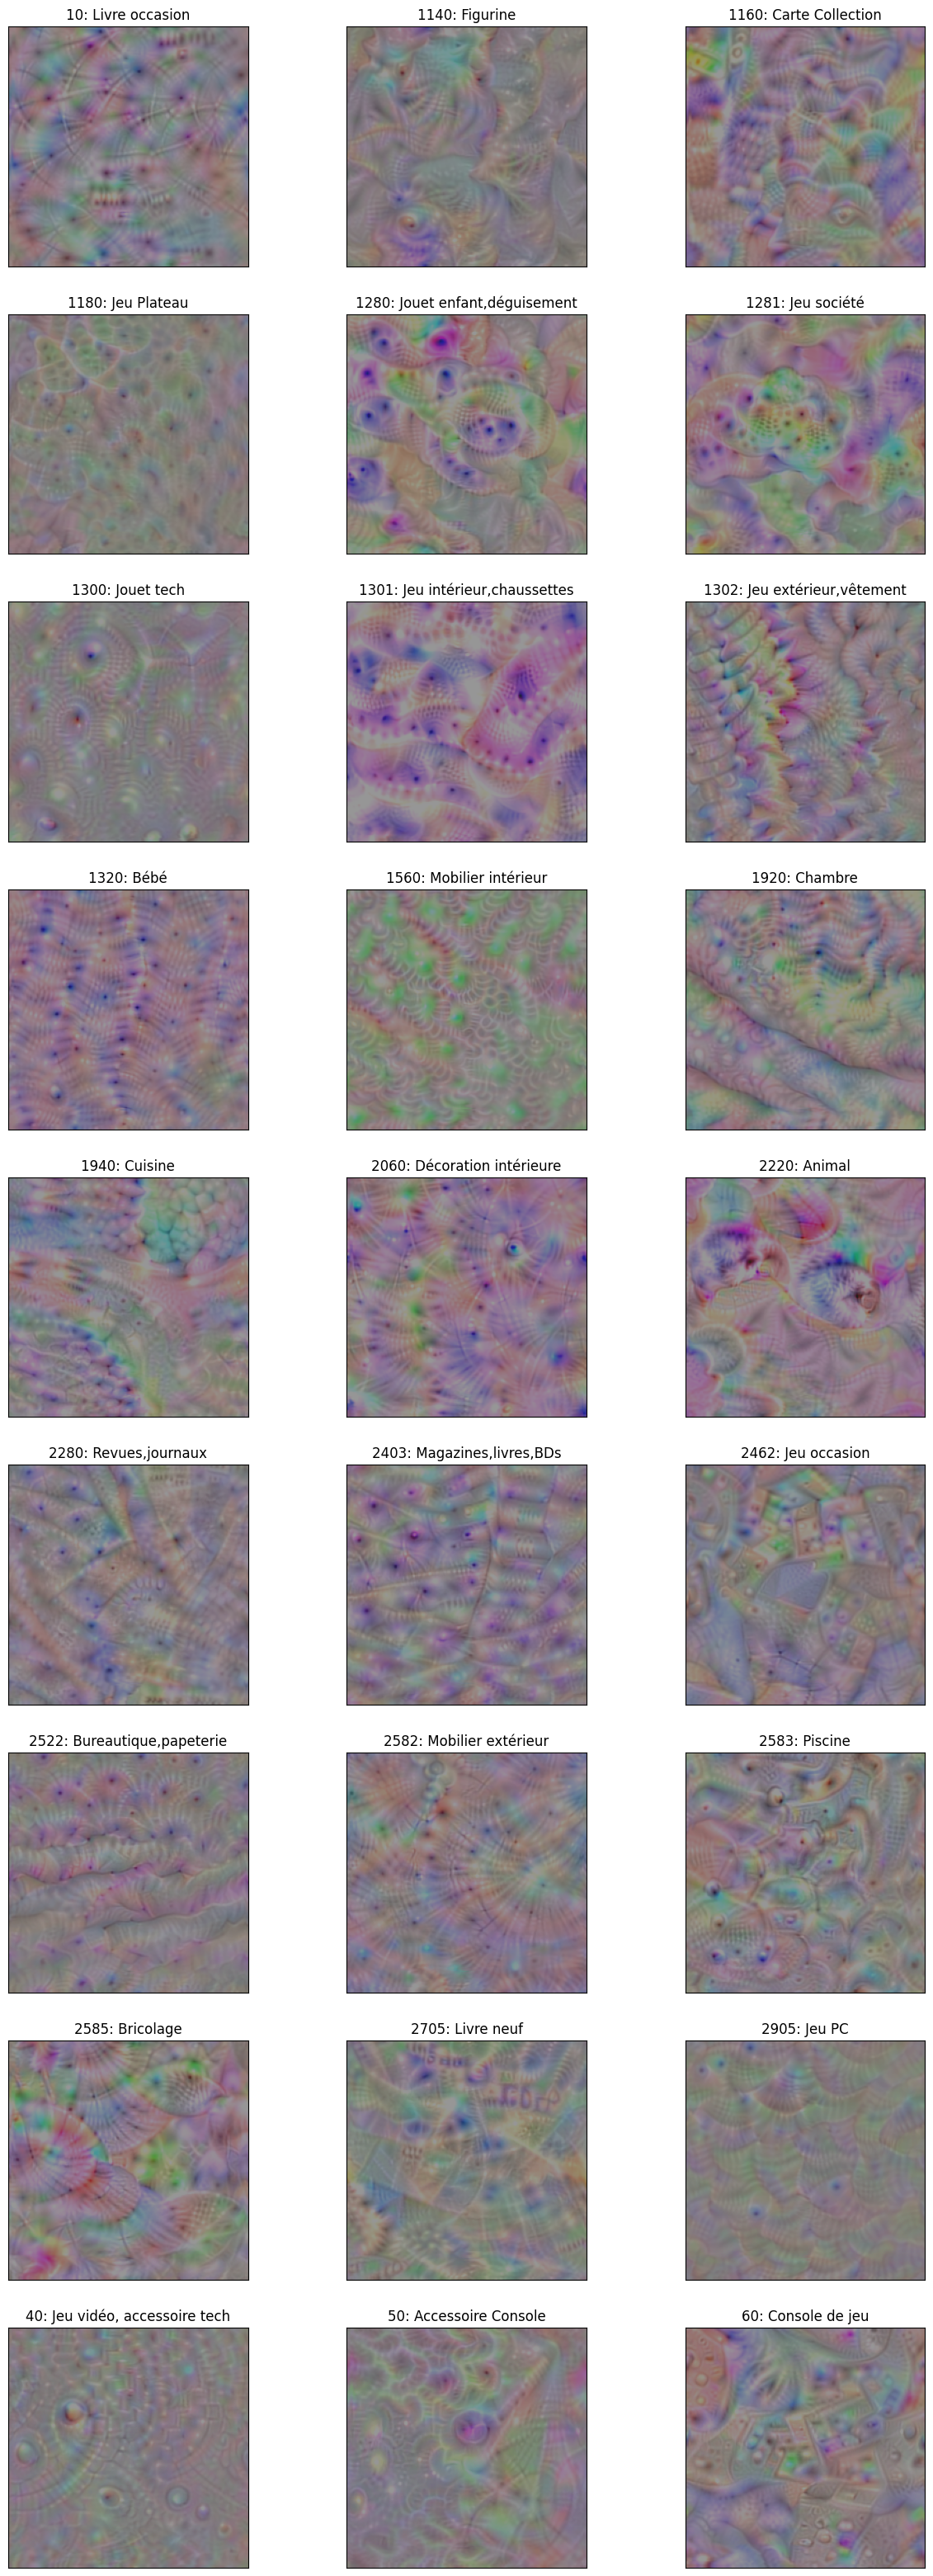

In [ ]:
plot_activation_images(activations)


## Test 2

In [ ]:

classes_nb = len(classes_keras)
def loss(output):
  output = [tf.reduce_max(output[:,i]) for i in range(classes_nb)]
  return tuple(output)


# Generate a random seed for each activation
seed_input = tf.random.uniform((classes_nb, 224, 224, 3), 0, 255)

# Generate activations and convert into images
activations = visualize_activation(loss, seed_input=seed_input, steps=512, input_range=(30,150))


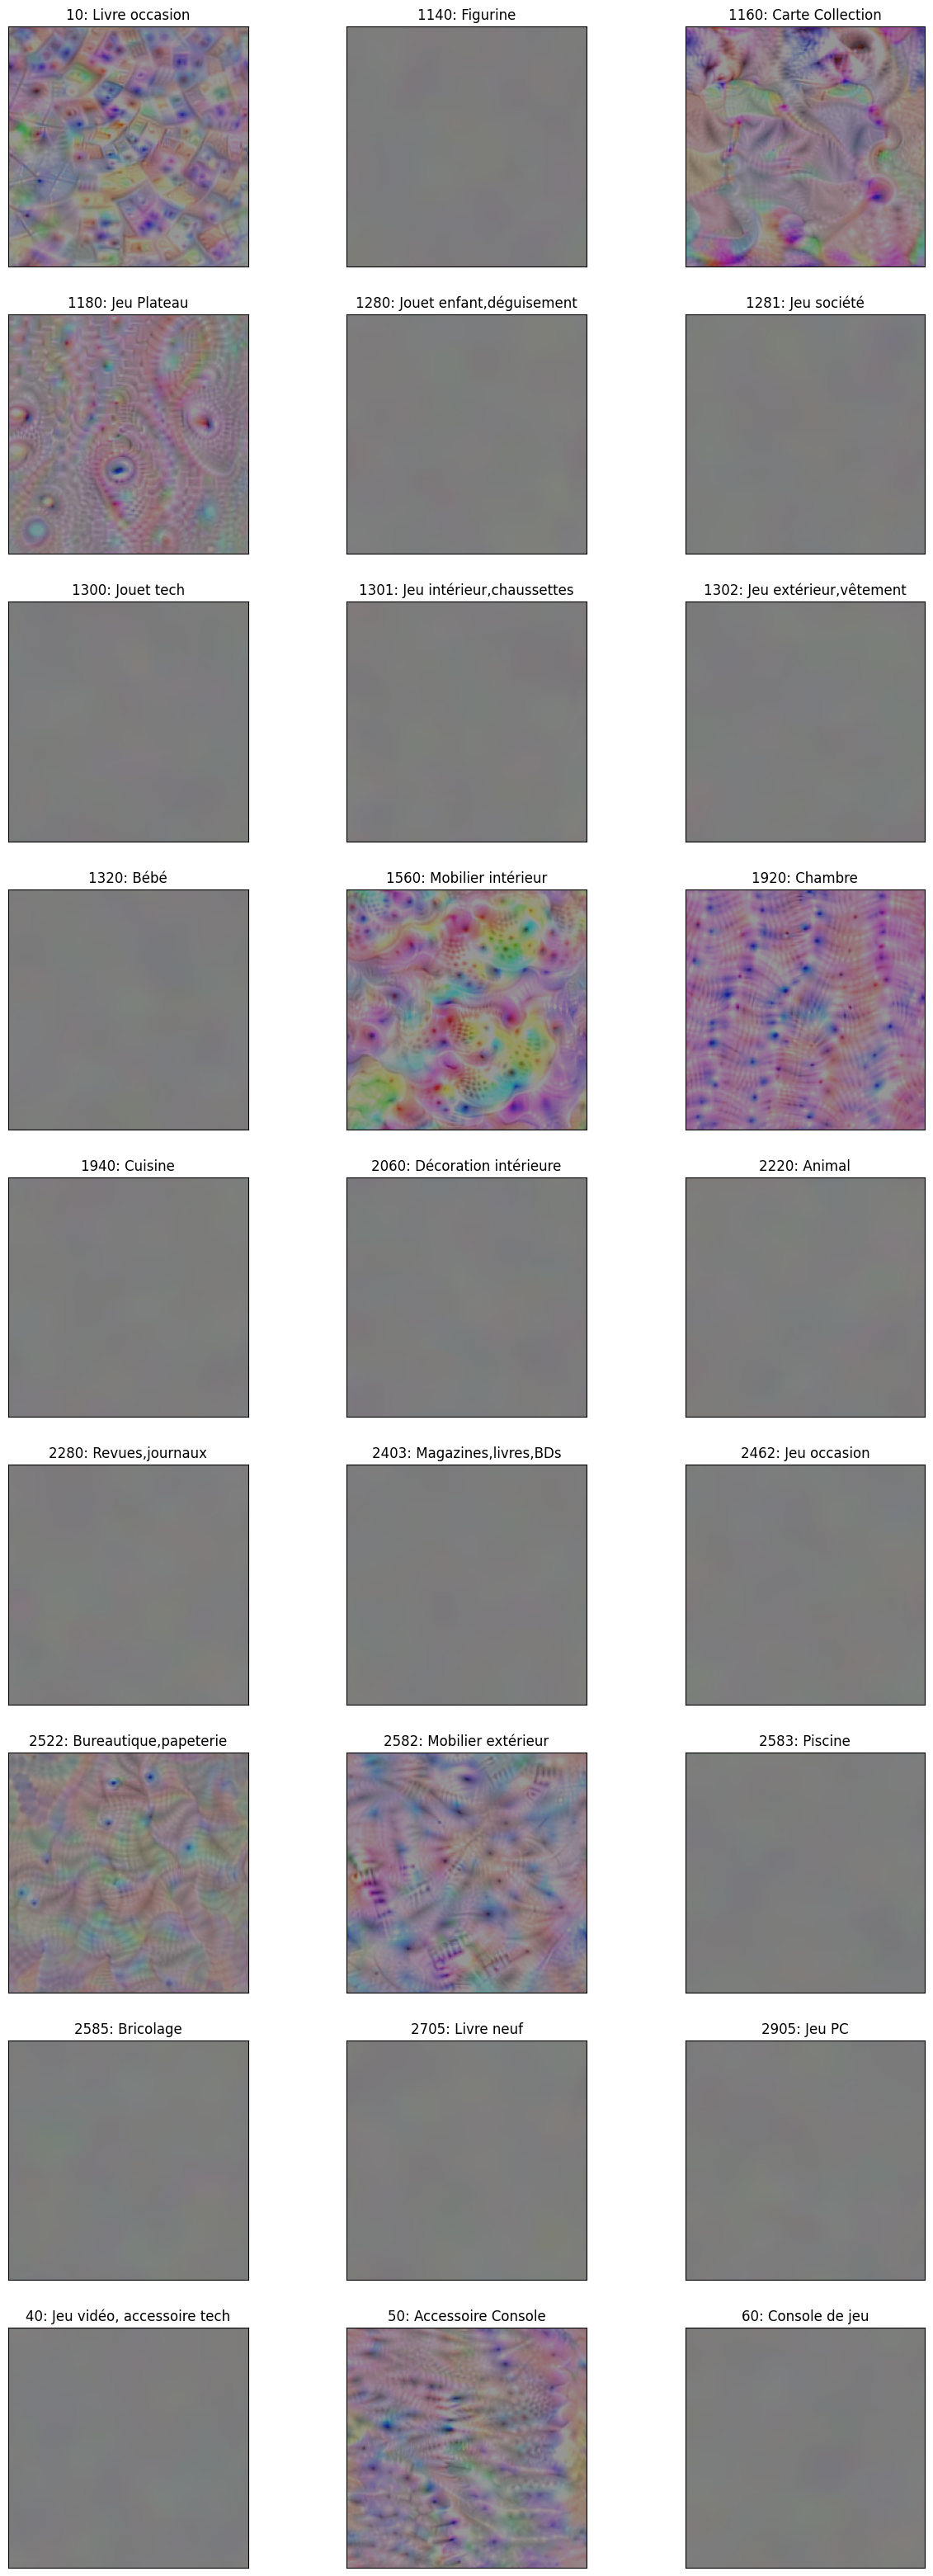

In [ ]:
plot_activation_images(activations)

In [ ]:
# verification
if False:
  img_index = 1
  predictions = model.predict(np.array([images[img_index]]))[0]
  predicted_class = np.argmax(predictions)
  print("predicted class=",predicted_class, (" probability=%.2f" % predictions[predicted_class] ))
